# Hospital ward dynamic contact network

Notebook permettant d'analyser le graphe de contacts entre le personnel soignant, administratif et les patients d'un service hospitalier.

## Chargement et préparation des données

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


df = pd.read_csv("./data/detailed_list_of_contacts_Hospital.dat", delimiter="\t", header=None)

df.head()

,0,1,2,3,4
0,140,1157,1232,MED,ADM
1,160,1157,1191,MED,MED
2,500,1157,1159,MED,MED
3,520,1157,1159,MED,MED
4,560,1159,1191,MED,MED


### Graphe simple
Une seule arête entre les noeuds mais pondérée par la somme des durées des contacts entre les noeuds

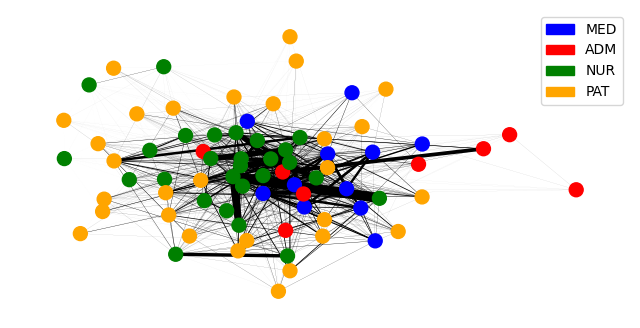

In [4]:
# Simple weighted Graph

G = nx.Graph()

# Construction du graphe
for (i, j), group in df.groupby([1, 2]):
    
    Si = group[3].iloc[0]   # catégorie du noeud i
    Sj = group[4].iloc[0]   # catégorie du noeud j

    # Ajouter les noeuds
    G.add_node(i, category=Si)
    G.add_node(j, category=Sj)

    # Somme des temps de contact
    total_t = group[0].sum()

    # Ajouter l'arête pondérée
    G.add_edge(i, j, t=total_t)


# Plot d'un premier graphe pondéré

# Couleurs des noeuds des différentes catégories
color_map = {
    "MED": "blue",
    "ADM": "red",
    "NUR": "green",
    "PAT": "orange"
}

node_colors = [color_map[G.nodes[n]["category"]] for n in G.nodes()]

plt.figure(figsize=(8, 4))

# Ajout de la légende
legend_handles = [mpatches.Patch(color=color, label=cat) 
                  for cat, color in color_map.items()]
plt.legend(handles=legend_handles, loc="best")

# Normalisation pour affichage des arêtes pondérées
edges = G.edges()
edge_weights = [G[u][v]["t"] for u, v in edges]
max_w = max(edge_weights)
edge_widths = [10 * (w / max_w) for w in edge_weights] 


# Génération du graphe
nx.draw(
    G,
    pos=nx.spring_layout(G, seed=42),
    node_color=node_colors,
    node_size=100,
    width=edge_widths,
    edge_color="black",
    with_labels=False
)
plt.savefig('./figures/hospital_weighted_graph.png')
plt.show()


## Analyse

### Première propriétés basiques

#### Distribution des degrés

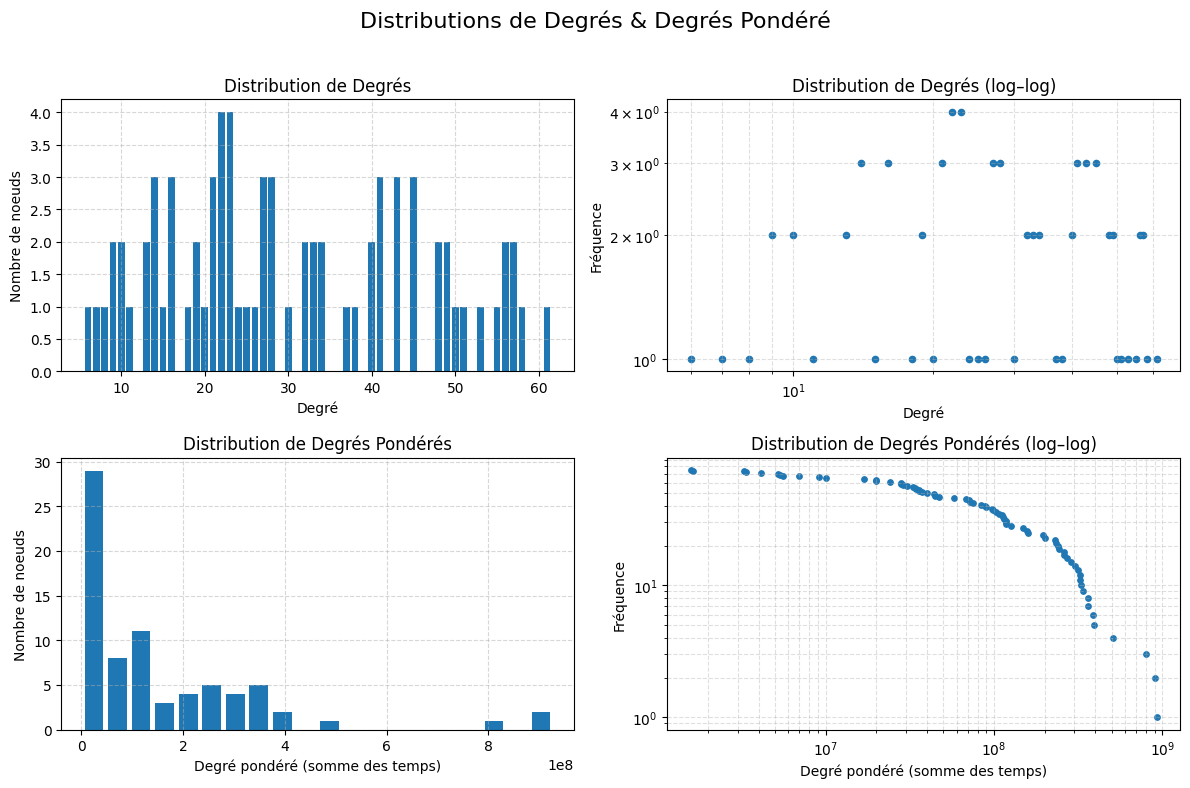

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

def plot_combined_degree_distributions(G, savepath=None):
    """
    Produit une figure 2x2 avec :
      1. Histogramme du degré
      2. Log-log scatter (degré)
      3. Histogramme du degré pondéré
      4. Log-log rank plot du degré pondéré
    """

    # --------------------------
    # 1. DEGRÉS NON PONDÉRÉS
    # --------------------------

    degrees = [d for _, d in G.degree()]

    # histogramme
    bins_deg = range(min(degrees), max(degrees) + 2)

    # log-log scatter
    degree_count = {}
    for d in degrees:
        degree_count[d] = degree_count.get(d, 0) + 1

    x_deg = np.array(list(degree_count.keys()))
    y_deg = np.array(list(degree_count.values()))

    # --------------------------
    # 2. DEGRÉS PONDÉRÉS (STRENGTH)
    # --------------------------

    weighted_degrees = [d for _, d in G.degree(weight="t")]

    # histogramme weighted
    bins_wdeg = 20

    # rank plot (log-log)
    wdeg_sorted = np.sort(weighted_degrees)[::-1]
    ranks = np.arange(1, len(wdeg_sorted) + 1)

    # --------------------------
    # FIGURE COMBINÉE
    # --------------------------

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle("Distributions de Degrés & Degrés Pondéré", fontsize=16)

    # --- 1. Histogramme du degré ---
    axes[0, 0].hist(degrees, bins=bins_deg, align='left', rwidth=0.8)
    axes[0, 0].set_title("Distribution de Degrés")
    axes[0, 0].set_xlabel("Degré")
    axes[0, 0].set_ylabel("Nombre de noeuds")
    axes[0, 0].grid(True, linestyle='--', alpha=0.5)

    # --- 2. Log-log scatter (degree) ---
    axes[0, 1].scatter(x_deg, y_deg, s=20)
    axes[0, 1].set_xscale("log")
    axes[0, 1].set_yscale("log")
    axes[0, 1].set_title("Distribution de Degrés (log–log)")
    axes[0, 1].set_xlabel("Degré")
    axes[0, 1].set_ylabel("Fréquence")
    axes[0, 1].grid(True, which="both", linestyle="--", alpha=0.4)

    # --- 3. Histogramme du weighted degree ---
    axes[1, 0].hist(weighted_degrees, bins=bins_wdeg, rwidth=0.8)
    axes[1, 0].set_title("Distribution de Degrés Pondérés")
    axes[1, 0].set_xlabel("Degré pondéré (somme des temps)")
    axes[1, 0].set_ylabel("Nombre de noeuds")
    axes[1, 0].grid(True, linestyle='--', alpha=0.5)

    # --- 4. Log-log rank plot weighted degree ---
    axes[1, 1].scatter(wdeg_sorted, ranks, s=15)
    axes[1, 1].set_xscale("log")
    axes[1, 1].set_yscale("log")
    axes[1, 1].set_title("Distribution de Degrés Pondérés (log–log)")
    axes[1, 1].set_xlabel("Degré pondéré (somme des temps)")
    axes[1, 1].set_ylabel("Fréquence")
    axes[1, 1].grid(True, which='both', linestyle='--', alpha=0.4)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches='tight')

    plt.show()


# ---------------------------
# APPEL DE LA FONCTION
# ---------------------------

plot_combined_degree_distributions(G, savepath="figures/hospital_degree_combined.png")


In [6]:
# Extraction des 10 noeuds les plus important 
cat = nx.get_node_attributes(G, "category")

df_deg = pd.DataFrame({
    "node": [n for n, d in G.degree()],
    "degree": [d for n, d in G.degree()],
    "weighted_degree": [d for n, d in G.degree(weight="t")],
    "category": [cat[n] for n in G.nodes()],
})

# sur base de leur degré
print(df_deg.sort_values("degree", ascending=False).head(10))

# sur base de leur degré pondéré
print(df_deg.sort_values("weighted_degree", ascending=False).head(10))


    node  degree  weighted_degree category
0   1098      61        286002920      ADM
22  1193      58        393702320      NUR
6   1115      57        926630540      NUR
16  1164      57        329926520      NUR
34  1295      56        802284520      NUR
28  1210      56        900560220      NUR
4   1109      55        317852560      NUR
14  1157      53        508399720      MED
56  1658      51        272655960      ADM
10  1144      50        323983160      MED
    node  degree  weighted_degree category
6   1115      57        926630540      NUR
28  1210      56        900560220      NUR
34  1295      56        802284520      NUR
14  1157      53        508399720      MED
22  1193      58        393702320      NUR
26  1207      49        386700600      NUR
55  1629      30        361407300      NUR
29  1221      41        360233860      MED
12  1149      48        336825480      NUR
16  1164      57        329926520      NUR


#### Coeffcient de Clustering

In [7]:
# clustering non pondéré moyen
avg_clust = nx.average_clustering(G)
print("Average clustering (unweighted) :", avg_clust)

# Local clustering coefficients (non pondéré)
clust_nodes = nx.clustering(G) 

nx.set_node_attributes(G, clust_nodes, "clustering")

# Récupérer category pour chaque noeud
cat = nx.get_node_attributes(G, "category")

# Construction dataframe
dfc = pd.DataFrame({
    "node": list(G.nodes()),
    "category": [cat[n] for n in G.nodes()],
    "clustering": [clust_nodes[n] for n in G.nodes()],
})

# Moyennes par catégorie
by_cat = dfc.groupby("category").agg({
    "clustering": ["mean", "median", "count"],
})
print(by_cat)

Average clustering (unweighted) : 0.6402796539914468
         clustering                
               mean    median count
category                           
ADM        0.701624  0.734392     8
MED        0.655725  0.641536    11
NUR        0.548132  0.558405    27
PAT        0.703291  0.707510    29


#### Centralité (non pondérée)

In [9]:
# Degree
degree_dict = dict(G.degree())

# Betweenness
betweenness_dict = nx.betweenness_centrality(G, normalized=True)

# Closeness
closeness_dict = nx.closeness_centrality(G)

# Katz centrality (alpha < 1/lambda_max)
katz_dict = nx.katz_centrality_numpy(G, alpha=0.005, beta=1.0)

# PageRank non pondéré
pagerank_dict = nx.pagerank(G, weight=None)

# ================
# DATAFRAME COMPLET
# ================

df_cent = pd.DataFrame({
    'node': list(G.nodes()),
    'category': [G.nodes[n]['category'] for n in G.nodes()],
    'degree': [degree_dict[n] for n in G.nodes()],
    'betweenness': [betweenness_dict[n] for n in G.nodes()],
    'closeness': [closeness_dict[n] for n in G.nodes()],
    'katz': [katz_dict[n] for n in G.nodes()],
    'pagerank': [pagerank_dict[n] for n in G.nodes()],
})

# ================
# FONCTION TOP-K
# ================

def show_topk(df, measure, k=10):
    top = df.sort_values(by=measure, ascending=False).head(k)
    print(f"\n=== Top {k} – {measure} ===")
    print(top[['node', 'category', measure]].to_string(index=False))
    return top

# Appels : affichage des tables
top_degree     = show_topk(df_cent, 'degree')
top_betweenness = show_topk(df_cent, 'betweenness')
top_closeness   = show_topk(df_cent, 'closeness')
top_katz        = show_topk(df_cent, 'katz')
top_pagerank    = show_topk(df_cent, 'pagerank')



=== Top 10 – degree ===
 node category  degree
 1098      ADM      61
 1193      NUR      58
 1115      NUR      57
 1164      NUR      57
 1295      NUR      56
 1210      NUR      56
 1109      NUR      55
 1157      MED      53
 1658      ADM      51
 1144      MED      50

=== Top 10 – betweenness ===
 node category  betweenness
 1098      ADM     0.040408
 1193      NUR     0.035156
 1164      NUR     0.031266
 1115      NUR     0.028689
 1109      NUR     0.027835
 1295      NUR     0.026828
 1210      NUR     0.026450
 1658      ADM     0.022657
 1190      NUR     0.022165
 1157      MED     0.021652

=== Top 10 – closeness ===
 node category  closeness
 1098      ADM   0.850575
 1193      NUR   0.822222
 1115      NUR   0.813187
 1164      NUR   0.813187
 1295      NUR   0.804348
 1210      NUR   0.804348
 1109      NUR   0.795699
 1157      MED   0.778947
 1658      ADM   0.762887
 1144      MED   0.755102

=== Top 10 – katz ===
 node category     katz
 1098      ADM 0.132616

### Modèles de réseau

In [10]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Données du graphe réel
# -----------------------------

N = G.number_of_nodes()
M = G.number_of_edges()

# Probabilité ER correspondante
p = (2*M) / (N*(N-1))

# -----------------------------
# Modèles
# -----------------------------

# 1) ER random graph
G_er = nx.gnp_random_graph(N, p)

# 2) Configuration Model (avec préservation du degree sequence)
deg_seq = [d for _, d in G.degree()]
G_cm_multi = nx.configuration_model(deg_seq)   # multigraph
G_cm = nx.Graph(G_cm_multi)                    # conversion en graphe simple
G_cm.remove_edges_from(nx.selfloop_edges(G_cm))

# 3) Barabási–Albert
# Choix de m = M/N approx = degree moyen / 2
m_ba = max(1, int(np.mean(deg_seq) // 2))
G_ba = nx.barabasi_albert_graph(N, m_ba)

# -----------------------------
# Fonction utilitaire : mesures
# -----------------------------

def summary_stats(H, name):
    print(f"\n=== {name} ===")
    print("Nodes:", H.number_of_nodes())
    print("Edges:", H.number_of_edges())
    print("Density:", nx.density(H))
    print("Average clustering:", nx.average_clustering(H))
    try:
        print("Average shortest path length:", nx.average_shortest_path_length(H))
    except:
        print("Average shortest path length: not connected")

summary_stats(G, "Real Hospital Graph")
summary_stats(G_er, "ER model")
summary_stats(G_cm, "Configuration Model")
summary_stats(G_ba, "BA model")



=== Real Hospital Graph ===
Nodes: 75
Edges: 1139
Density: 0.4104504504504505
Average clustering: 0.6402796539914468
Average shortest path length: 1.597837837837838

=== ER model ===
Nodes: 75
Edges: 1214
Density: 0.43747747747747745
Average clustering: 0.4437008054543132
Average shortest path length: 1.5625225225225226

=== Configuration Model ===
Nodes: 75
Edges: 848
Density: 0.3055855855855856
Average clustering: 0.3860689189054437
Average shortest path length: 1.701981981981982

=== BA model ===
Nodes: 75
Edges: 900
Density: 0.32432432432432434
Average clustering: 0.4234734984262887
Average shortest path length: 1.676036036036036


In [11]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Données du graphe réel
# -----------------------------

N = G.number_of_nodes()
M = G.number_of_edges()

# Probabilité ER correspondante
p = (2*M) / (N*(N-1))

# -----------------------------
# Modèles
# -----------------------------

# 1) ER random graph
G_er = nx.gnp_random_graph(N, p)

# 2) Configuration Model (avec préservation du degree sequence)
deg_seq = [d for _, d in G.degree()]
G_cm_multi = nx.configuration_model(deg_seq)   # multigraph
G_cm = nx.Graph(G_cm_multi)                    # conversion en graphe simple
G_cm.remove_edges_from(nx.selfloop_edges(G_cm))

# 3) Barabási–Albert
# Choix de m = M/N approx = degree moyen / 2
m_ba = max(1, int(np.mean(deg_seq) // 2))
G_ba = nx.barabasi_albert_graph(N, m_ba)

# -----------------------------
# Fonction utilitaire : mesures
# -----------------------------

def summary_stats(H, name):
    print(f"\n=== {name} ===")
    print("Nodes:", H.number_of_nodes())
    print("Edges:", H.number_of_edges())
    print("Density:", nx.density(H))
    print("Average clustering:", nx.average_clustering(H))
    try:
        print("Average shortest path length:", nx.average_shortest_path_length(H))
    except:
        print("Average shortest path length: not connected")

summary_stats(G, "Real Hospital Graph")
summary_stats(G_er, "ER model")
summary_stats(G_cm, "Configuration Model")
summary_stats(G_ba, "BA model")



=== Real Hospital Graph ===
Nodes: 75
Edges: 1139
Density: 0.4104504504504505
Average clustering: 0.6402796539914468
Average shortest path length: 1.597837837837838

=== ER model ===
Nodes: 75
Edges: 1149
Density: 0.41405405405405404
Average clustering: 0.41459532788591635
Average shortest path length: 1.585945945945946

=== Configuration Model ===
Nodes: 75
Edges: 854
Density: 0.30774774774774777
Average clustering: 0.41314967590333734
Average shortest path length: 1.703063063063063

=== BA model ===
Nodes: 75
Edges: 900
Density: 0.32432432432432434
Average clustering: 0.43934475388757166
Average shortest path length: 1.6756756756756757


### Détection de communautés (Louvain)

Modularity: 0.0962
Number of communities: 4
Community sizes (id : size):
  0 : 22
  1 : 17
  3 : 20
  2 : 16

Composition des communautés :
category   ADM  MED  NUR  PAT  size
community                          
0            3    7    6    6    22
3            4    4    5    7    20
1            1    0    8    8    17
2            0    0    8    8    16


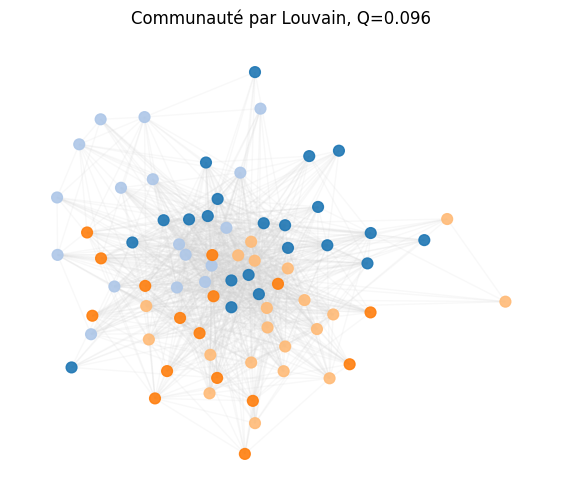

In [12]:
import community as community_louvain

# ---------------------------
# 1) Partition Louvain
# ---------------------------

partition = community_louvain.best_partition(G)
nx.set_node_attributes(G, partition, "community")

# ---------------------------
# 2) Modularity & community sizes
# ---------------------------

modularity = community_louvain.modularity(partition, G)

from collections import Counter
comm_counts = Counter(partition.values())
n_comms = len(comm_counts)

print(f"Modularity: {modularity:.4f}")
print(f"Number of communities: {n_comms}")
print("Community sizes (id : size):")
for cid, size in comm_counts.items():
    print(f"  {cid} : {size}")

# ---------------------------
# 3) Composition par catégorie
# ---------------------------

df_nodes = pd.DataFrame({
    "node": list(G.nodes()),
    "category": [G.nodes[n]['category'] for n in G.nodes()],
    "community": [partition[n] for n in G.nodes()]
})

comp_table = pd.crosstab(df_nodes["community"], df_nodes["category"])
comp_table["size"] = comp_table.sum(axis=1)
comp_table = comp_table.sort_values("size", ascending=False)

print("\nComposition des communautés :")
print(comp_table)

# ---------------------------
# 4) Affichage du graphe coloré par communauté
# ---------------------------

pos = nx.spring_layout(G, seed=42)

# palette
import matplotlib.cm as cm
palette = [cm.tab20(i) for i in range(20)]
colors = [palette[partition[n] % 20] for n in G.nodes()]

plt.figure(figsize=(7, 6))
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=60, alpha=0.9)
nx.draw_networkx_edges(G, pos, edge_color="lightgray", alpha=0.15)
plt.axis("off")
plt.title(f"Communauté par Louvain, Q={modularity:.3f}")
plt.savefig('./figures/hospital_communities_louvain.png')
plt.show()


#### Dynamique

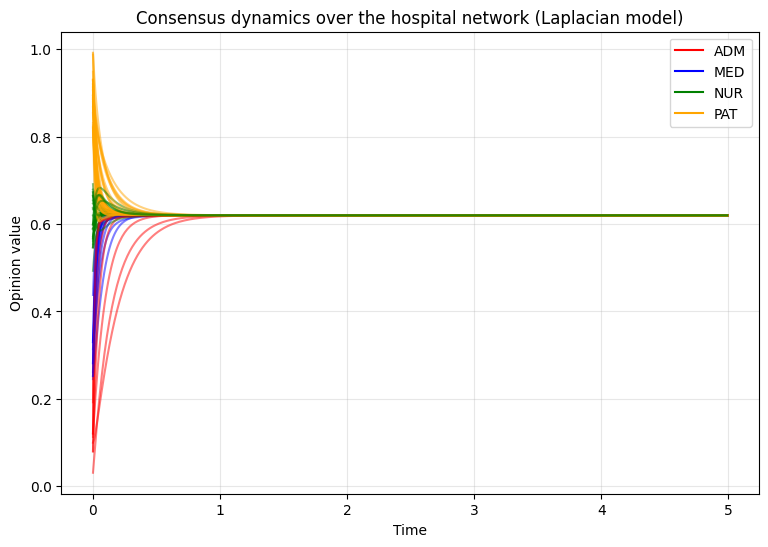

Final consensus value ≈ 0.6199958866578701


In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# ---------------------------
# 1) Laplacian dynamics  dx/dt = -Lx
# ---------------------------

# Laplacian matrix
L = nx.laplacian_matrix(G).astype(float).todense()

# initial conditions based on categories
# (gives a small offset per group to visualize group evolution)
cat_map = {"ADM": 0.1, "MED": 0.3, "NUR": 0.6, "PAT": 0.9}
x0 = np.array([cat_map[G.nodes[n]["category"]] + 0.05*np.random.randn()
               for n in G.nodes()])

# simulation parameters
dt = 0.01
T = 5
times = np.arange(0, T, dt)

# store trajectories
trajectories = []

x = x0.copy()
for t in times:
    trajectories.append(x.copy())
    x = x - dt * (L @ x)

trajectories = np.array(trajectories)  # shape (time, nodes)

# ---------------------------
# 2) Plot with colors by category
# ---------------------------

colors = {
    "ADM": "red",
    "MED": "blue",
    "NUR": "green",
    "PAT": "orange"
}

plt.figure(figsize=(9,6))

for i, n in enumerate(G.nodes()):
    plt.plot(times, trajectories[:, i],
             color=colors[G.nodes[n]["category"]],
             alpha=0.5)

plt.xlabel("Time")
plt.ylabel("Opinion value")
plt.title("Consensus dynamics over the hospital network")
plt.grid(alpha=0.3)

# custom legend
for cat, col in colors.items():
    plt.plot([], [], color=col, label=cat)
plt.legend()

plt.show()

# consensus value
print("Final consensus value ≈", float(trajectories[-1].mean()))


### Random Walk

In [14]:
# --- Transition matrix T (unweighted) ---
A = nx.to_numpy_array(G)
deg = A.sum(axis=1)
deg[deg == 0] = 1
T = A / deg[:, None]   # row-stochastic

# --- Power method ---
p = np.ones(G.number_of_nodes()) / G.number_of_nodes()
for _ in range(200):
    p = p @ T

# --- Build dataframe ---
df_rw = pd.DataFrame({
    "node": list(G.nodes()),
    "category": [G.nodes[n]["category"] for n in G.nodes()],
    "stationary": p
})

df_rw = df_rw.sort_values("stationary", ascending=False)

print(df_rw.head(10))

    node category  stationary
0   1098      ADM    0.026778
22  1193      NUR    0.025461
6   1115      NUR    0.025022
16  1164      NUR    0.025022
34  1295      NUR    0.024583
28  1210      NUR    0.024583
4   1109      NUR    0.024144
14  1157      MED    0.023266
56  1658      ADM    0.022388
10  1144      MED    0.021949


### Mean First passage

In [17]:
import random

def simulate_MFPT(G, source, target, n_sim=500):
    steps = []
    for _ in range(n_sim):
        current = source
        for t in range(1, 2000):
            neighbors = list(G.neighbors(current))
            if not neighbors:
                break
            current = random.choice(neighbors)
            if current == target:
                steps.append(t)
                break
    return np.mean(steps)

# Choix de quelques nœuds typiques
sample_sources = {
    "ADM":   next(n for n in G.nodes() if G.nodes[n]["category"]=="ADM"),
    "MED":   next(n for n in G.nodes() if G.nodes[n]["category"]=="MED"),
    "NUR":   next(n for n in G.nodes() if G.nodes[n]["category"]=="NUR"),
    "PAT":   next(n for n in G.nodes() if G.nodes[n]["category"]=="PAT")
}

targets = list(G.nodes())[:30]

mfpt_results = []

for label, src in sample_sources.items():
    for t in targets:
        mfpt = simulate_MFPT(G, src, t, n_sim=200)
        mfpt_results.append((label, src, t, G.nodes[t]["category"], mfpt))

mfpt_df = pd.DataFrame(mfpt_results, columns=["src_cat","src_id","target","target_cat","MFPT"])
print(mfpt_df.groupby(["src_cat","target_cat"])["MFPT"].mean())

src_cat  target_cat
ADM      ADM           54.831667
         MED           72.970556
         NUR           55.673611
MED      ADM           58.900000
         MED           72.947222
         NUR           56.488056
NUR      ADM           61.365000
         MED           76.838333
         NUR           55.238333
PAT      ADM           58.191667
         MED           72.575000
         NUR           55.074722
Name: MFPT, dtype: float64


### Markov stability

In [18]:
from numpy.linalg import matrix_power

times = [1, 2, 5, 10]
for t in times:
    Pt = matrix_power(T, t)
    retention = np.diag(Pt)  # probabilité de revenir à soi-même
    print(f"t = {t}, mean retention = {retention.mean():.4f}")

t = 1, mean retention = 0.0000
t = 2, mean retention = 0.0318
t = 5, mean retention = 0.0132
t = 10, mean retention = 0.0133


### Infomap